<a href="https://colab.research.google.com/github/mintseok/MachineLearning/blob/main/Deep_Learning_From_Scratch_3/Automatic_BackPropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 구글 드라이브 마운트 하기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd "/content/drive/My Drive"

/content/drive/My Drive


In [3]:
mkdir "밑시딥3"

mkdir: cannot create directory ‘밑시딥3’: File exists


In [4]:
cd "밑시딥3"

/content/drive/My Drive/밑시딥3


# 처음이니, 밑시딥3 깃허브 클론해오기

In [5]:
!git clone https://github.com/WegraLee/deep-learning-from-scratch-3.git

fatal: destination path 'deep-learning-from-scratch-3' already exists and is not an empty directory.


In [6]:
cd /content/drive/MyDrive/밑시딥3/deep-learning-from-scratch-3

/content/drive/MyDrive/밑시딥3/deep-learning-from-scratch-3


# 변수와 친해지기 -- step01.py

In [7]:
class Variable:
  def __init__(self, data):
    self.data = data

In [8]:
import numpy as np

data = np.array(1.0)
x = Variable(data)
print(x.data)

1.0


In [9]:
# numpy에서는 차원을 tensor라고 부르기도 한다. ex) 0차원 텐서, 1차원 텐서, ..

# 함수와 친해지기 -- step02.py

In [10]:
class Function:
  def __call__(self, input):
    x = input.data
    y = x**2
    output = Variable(y) # Variable 형태로 변환
    return output

In [11]:
x = Variable(np.array(10))
f = Function()
y = f(x)

print(type(y))
print(y.data)

<class '__main__.Variable'>
100


In [12]:
class Function:
  def __call__(self, input):
    x = input.data
    y = self.forward(x) # 구체적인 계산은 forward 메서드에서 한다.
    output = Variable(y)
    return output
  def forward(self, x):
    raise NotImplementedError()

class Square(Function):
  def forward(self, x):
    return x**2

In [13]:
x = Variable(np.array(10))
f = Square()
y = f(x)
print(type(y))
print(y.data)

<class '__main__.Variable'>
100


In [14]:
class Exp(Function):
  def forward(self, x):
    return np.exp(x)

In [15]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)
print(y.data)

1.648721270700128


위의 과정을 그림으로 나타내면 다음과 같다

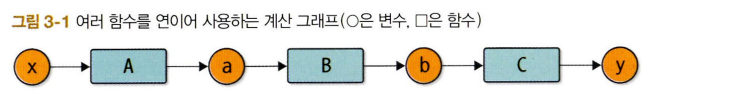

# 수치 미분 numerical difference

In [16]:
def numerical_diff(f, x, eps=1e-4):
  x0 = Variable(x.data - eps)
  x1 = Variable(x.data + eps)
  y0 = f(x0)
  y1 = f(x1)
  return (y1.data - y0.data) / (2 * eps)

In [17]:
f = Square()
x = Variable(np.array(2.0))
dy = numerical_diff(f, x)
print(dy) # 4.000000000004 -> 정확한 미분은 4.0일 것이지만, 수치 미분이기에 매우 작은 오차가 존재한다.

4.000000000004


# 수치 미분의 문제점

- 오차가 포함되어 있음

- 계산량이 많다

# 따라서 역전파 사용 !!

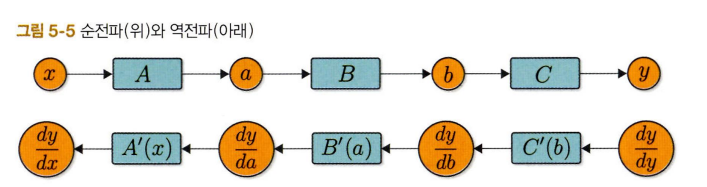

In [18]:
# Variable 갱신 -> grad를 저장하기 위한 변수 선언
class Variable:
  def __init__(self, data):
    self.data = data
    self.grad = None

In [19]:
# Function 갱신 -> 오차역전파법 추가
class Function:
  def __call__(self, input):
    x = input.data
    y = self.forward(x) # 구체적인 계산은 forward 메서드에서 한다.
    output = Variable(y)
    self.input = input # 입력 변수를 기억(보관)한다.
    return output

  def forward(self, x):
    raise NotImplementedError()

  def backward(self, x):
    raise NotImplementedError

In [36]:
class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y

    def backward(self, gy):
        x = self.input.data
        gx = 2 * x * gy
        return gx


class Exp(Function):
    def forward(self, x):
        y = np.exp(x)
        return y

    def backward(self, gy):
        x = self.input.data
        gx = np.exp(x) * gy
        return gx

In [21]:
# 순전파
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

In [22]:
# 역전파
y.grad = np.array(1.0) # 위에서 내려오는 흐름이기 때문에 1로 설정
b.grad = C.backward(y.grad)
a.grad = B.backward(b.grad)
x.grad = A.backward(a.grad)
print(x.grad)

3.297442541400256


# 역전파 자동화

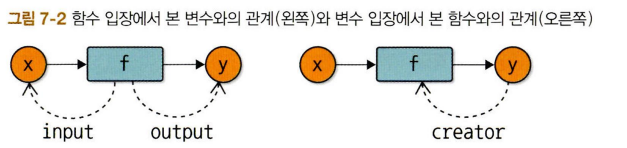

In [23]:
class Variable: # creator 변수 추가
  def __init__(self, data):
    self.data = data
    self.grad = None
    self.creator = None
  
  def set_creator(self, func):
    self.creator = func

class Function:
  def __call__(self, input):
    x = input.data
    y = self.forward(x)
    output = Variable(y)
    output.set_creator(self) # 출력 변수에 창조자를 설정한다.
    self.input = input
    self.output = output # 출력도 저장한다.
    return output

In [37]:
class Variable: # backward 추가
  def __init__(self, data):
    self.data = data
    self.grad = None
    self.creator = None
  
  def set_creator(self, func):
    self.creator = func

  def backward(self):
    f = self.creator # 1. 함수 가져오는 단계
    if f is not None:
      x = f.input # 2. 함수의 입력을 가져온다.
      x.grad = f.backward(self.grad) # 3. 함수의 backward 메서드를 호출한다.
      x.backward() # 하나 앞 변수의 backward 메서드를 호출한다. (재귀)

In [38]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

# 자동화된 역전파
y.grad = np.array(1.0)
y.backward()
print(x.grad)

3.297442541400256


# 재귀 형식이 아닌 반복문 형태로 재구현

In [39]:
class Variable: # backward 추가
  def __init__(self, data):
    self.data = data
    self.grad = None
    self.creator = None
  
  def set_creator(self, func):
    self.creator = func

  def backward(self):
    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      x, y = f.input, f.output
      x.grad = f.backward(y.grad)

      if x.creator is not None:
        funcs.append(x.creator)

In [40]:
A = Square()
B = Exp()
C = Square()

x = Variable(np.array(0.5))
a = A(x)
b = B(a)
y = C(b)

y.grad = np.array(1.0)
y.backward()
print(x.grad)

3.297442541400256


# 함수 간단하게 나타내기

In [41]:
def square(x):
  return Square()(x)

def exp(x):
  return Exp()(x)

In [43]:
x = Variable(np.array(0.5))
# a = square(x)
# b = exp(a)
# y = square(b)
y = square(exp(square(x)))

y.grad = np.array(1.0)
y.backward()
print(x.grad)

3.297442541400256


# y.grad = np.array(1.0) 안 하도록 class Variable에서 수정해주기

In [44]:
class Variable: # backward 추가
  def __init__(self, data):
    self.data = data
    self.grad = None
    self.creator = None
  
  def set_creator(self, func):
    self.creator = func

  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)
      
    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      x, y = f.input, f.output
      x.grad = f.backward(y.grad)

      if x.creator is not None:
        funcs.append(x.creator)

In [45]:
x = Variable(np.array(0.5))
y = square(exp(square(x)))

y.backward()
print(x.grad)

3.297442541400256


# ndarray (특정형식만 받도록) Variable 수정하기

In [47]:
class Variable: # backward 추가
  def __init__(self, data):
    if data is not None:
      if not isinstance(data, np.ndarray):
        raise TypeError('{}은(는) 지원하지 않습니다.'.format(type(data)))
        
    self.data = data
    self.grad = None
    self.creator = None
  
  def set_creator(self, func):
    self.creator = func

  def backward(self):
    if self.grad is None:
      self.grad = np.ones_like(self.data)
      
    funcs = [self.creator]
    while funcs:
      f = funcs.pop()
      x, y = f.input, f.output
      x.grad = f.backward(y.grad)

      if x.creator is not None:
        funcs.append(x.creator)

# 여기서 data type과 유의해야 할 부분

In [49]:
x = np.array(1.0) # 0차원 ndarray
y = x ** 2
print(type(x), x.ndim)
print(type(y))

#ndarray를 제곱하면, numpy.float64로 변한다!

<class 'numpy.ndarray'> 0
<class 'numpy.float64'>


In [50]:
def as_array(x):
  if np.isscalar(x):
    return np.array(x)
  return x

In [52]:
print(np.isscalar(np.float64(1.0)))
print(np.isscalar(2.0))
print(np.isscalar(np.array(2.0)))

True
True
False


# Function에서 위의 유의부분 적용시켜주기 (항상 ndarray가 입력되어야 하므로)

In [54]:
class Function:
  def __call__(self, input):
    x = input.data
    y = self.forward(x)
    output = Variable(as_array(y)) # 여기서 as_array 실행
    self.input = input 
    return output

  def forward(self, x):
    raise NotImplementedError()

  def backward(self, x):
    raise NotImplementedError

# 지금까지 한거 test 해보기

In [64]:
import unittest

class SquareTest(unittest.TestCase):
    def test_forward(self):
        x = Variable(np.array(2.0))
        y = square(x)
        expected = np.array(4.0)
        self.assertEqual(y.data, expected)

    def test_backward(self):
        x = Variable(np.array(3.0))
        y = square(x)
        y.backward()
        expected = np.array(6.0)
        self.assertEqual(x.grad, expected)

    def test_gradient_check(self):
        x = Variable(np.random.rand(1))
        y = square(x)
        y.backward()
        num_grad = numerical_diff(square, x)
        flg = np.allclose(x.grad, num_grad)
        self.assertTrue(flg)

In [65]:
unittest.main(argv=['first-arg-is-ignored'], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.008s

OK
